In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns
from PIL import Image

2025-11-18 11:28:24.555347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763465305.007760      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763465305.125296      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED=42
BATCH_SIZE=16

In [3]:
base_path='/kaggle/input/breakhis/BreaKHis_v1/'

In [4]:
folds = pd.read_csv('/kaggle/input/breakhis/Folds.csv')

In [5]:
benign_classes = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma']
malignant_classes = ['ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def get_labels(path):
    path_lower = path.lower()

    if 'benign' in path_lower:
        coarse_label = 'benign'
    else:
        coarse_label = 'malignant'

    fine_label = None
    for cls in benign_classes + malignant_classes:
        if cls in path_lower:
            fine_label = cls
            break

    return pd.Series([coarse_label, fine_label])

folds[['coarse_label', 'fine_label']] = folds['filename'].apply(get_labels)

In [6]:
folds['filename'] = folds['filename'].apply(lambda x: os.path.join(base_path, x))

In [7]:
folds.drop(columns=['fold','grp'], inplace=True)

In [8]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mag           39545 non-null  int64 
 1   filename      39545 non-null  object
 2   coarse_label  39545 non-null  object
 3   fine_label    39545 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [9]:
folds.head(8)

,mag,filename,coarse_label,fine_label
0,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
1,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
2,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
3,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
4,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
5,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
6,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
7,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


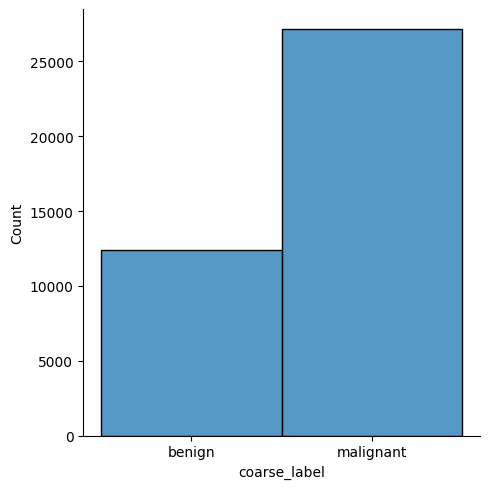

In [10]:
sns.displot(data=folds,x='coarse_label')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


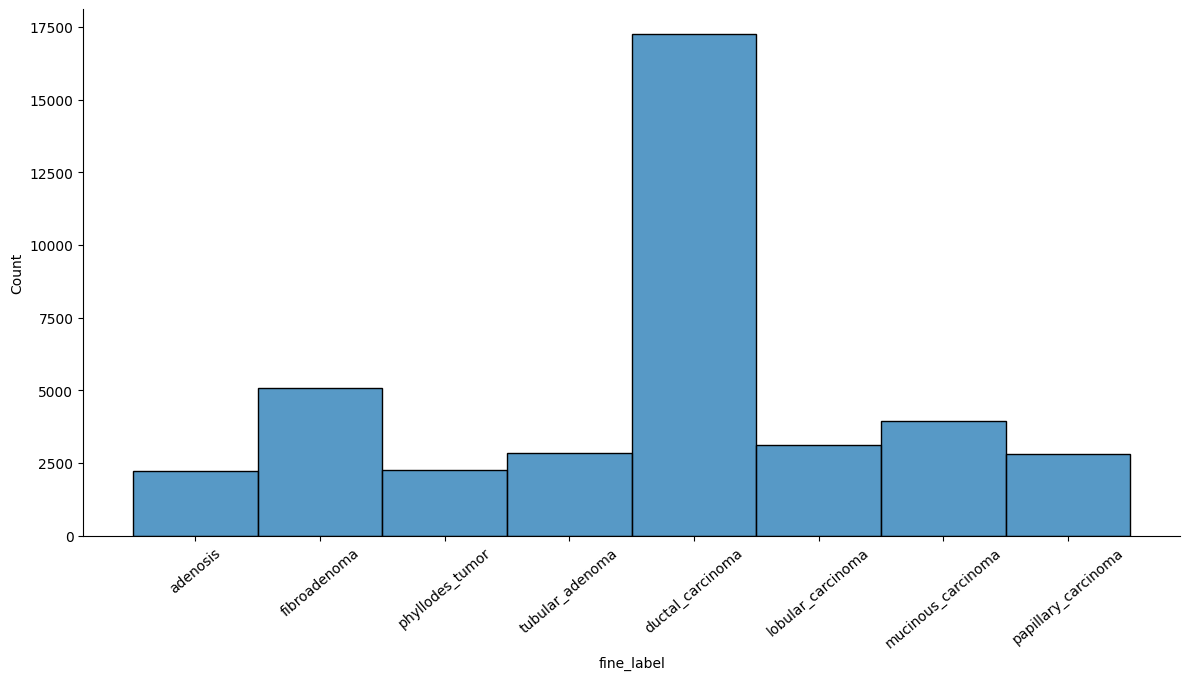

In [11]:
sns.displot(data=folds, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [12]:
test_df = folds.groupby('fine_label', group_keys=False).sample(n=850, random_state=SEED)
train_valid_df = folds.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

valid_df = train_valid_df.groupby('fine_label', group_keys=False).sample(frac=0.25, random_state=SEED)
train_df = train_valid_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training Set: ')
print(train_df['fine_label'].value_counts())
print('Total Count: ', train_df.shape[0])

print('Validation Set:')
print(valid_df['fine_label'].value_counts())
print('Total Count: ', valid_df.shape[0])

print('Test Set:')
print(test_df['fine_label'].value_counts())
print('Total Count: ', test_df.shape[0])

Training Set: 
fine_label
ductal_carcinoma       12304
fibroadenoma            3165
mucinous_carcinoma      2332
lobular_carcinoma       1710
tubular_adenoma         1496
papillary_carcinoma     1462
phyllodes_tumor         1061
adenosis                1028
Name: count, dtype: int64
Total Count:  24558
Validation Set:
fine_label
ductal_carcinoma       4101
fibroadenoma           1055
mucinous_carcinoma      778
lobular_carcinoma       570
tubular_adenoma         499
papillary_carcinoma     488
phyllodes_tumor         354
adenosis                342
Name: count, dtype: int64
Total Count:  8187
Test Set:
fine_label
adenosis               850
ductal_carcinoma       850
fibroadenoma           850
lobular_carcinoma      850
mucinous_carcinoma     850
papillary_carcinoma    850
phyllodes_tumor        850
tubular_adenoma        850
Name: count, dtype: int64
Total Count:  6800


     Train  Validation  Test
mag                         
40    6081        2091  1803
100   6510        2140  1755
200   6281        2087  1697
400   5686        1869  1545


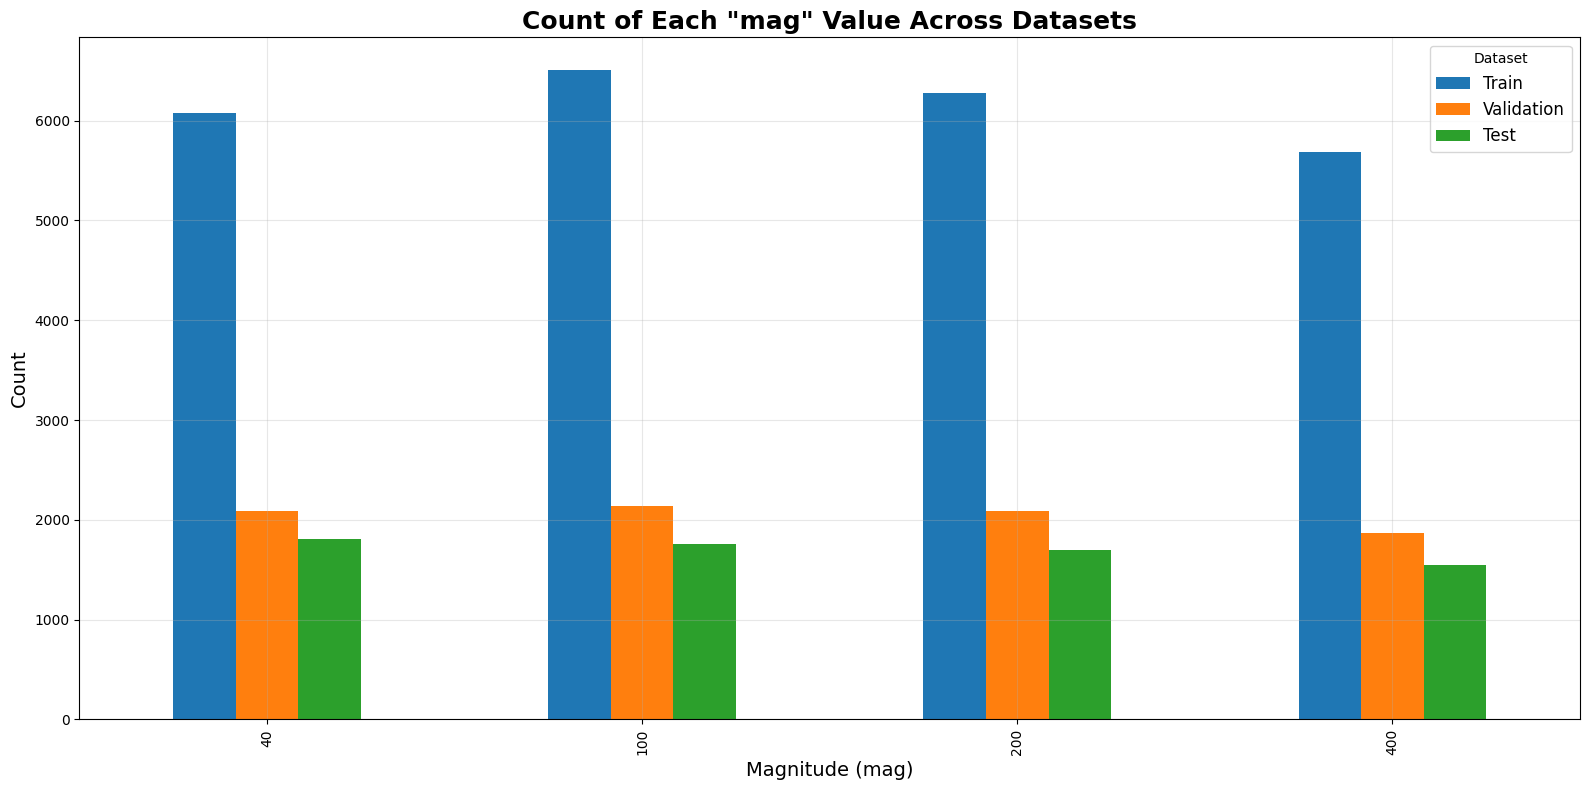

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Count occurrences of each mag per dataset
train_counts = train_df['mag'].value_counts().sort_index()
valid_counts = valid_df['mag'].value_counts().sort_index()
test_counts  = test_df['mag'].value_counts().sort_index()

# Combine into one DataFrame for comparison
mag_counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
}).fillna(0).astype(int)

# Display table (optional)
print(mag_counts_df.head())

# Plot side-by-side bars
mag_counts_df.plot(kind='bar', figsize=(16, 8))
plt.title('Count of Each "mag" Value Across Datasets', fontsize=18, fontweight='bold')
plt.xlabel('Magnitude (mag)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dataset', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


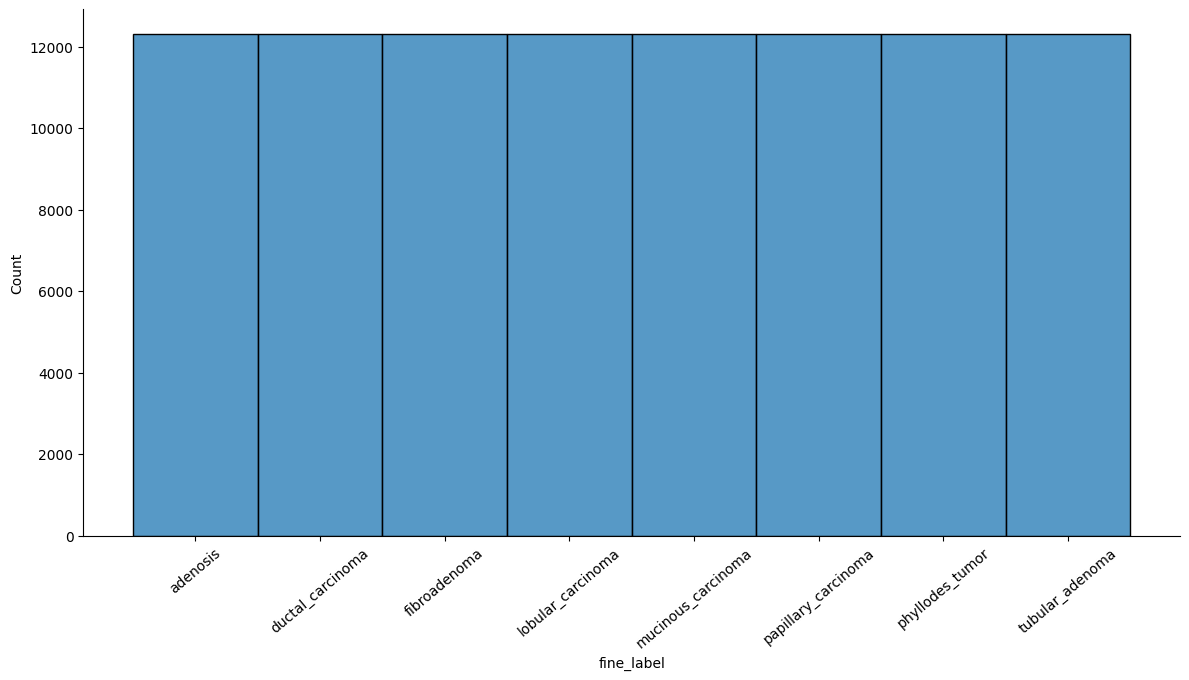

In [14]:
#upsampling
max_count = np.max(train_df.fine_label.value_counts())
min_count = np.min(train_df.fine_label.value_counts())
train_df = train_df.groupby('fine_label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.fine_label.value_counts()

sns.displot(data=train_df, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.2,1.0]
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# train_subset = train_df.sample(frac=0.1, random_state=42)
# val_subset = valid_df.sample(frac=0.1, random_state=42)

# train_generator = train_datagen.flow_from_dataframe(
#     train_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_dataframe(
#     val_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

Found 98432 validated image filenames belonging to 8 classes.
Found 8187 validated image filenames belonging to 8 classes.
Found 6800 validated image filenames belonging to 8 classes.


In [17]:
print(train_generator.image_shape)
print(val_generator.image_shape)
print(test_generator.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


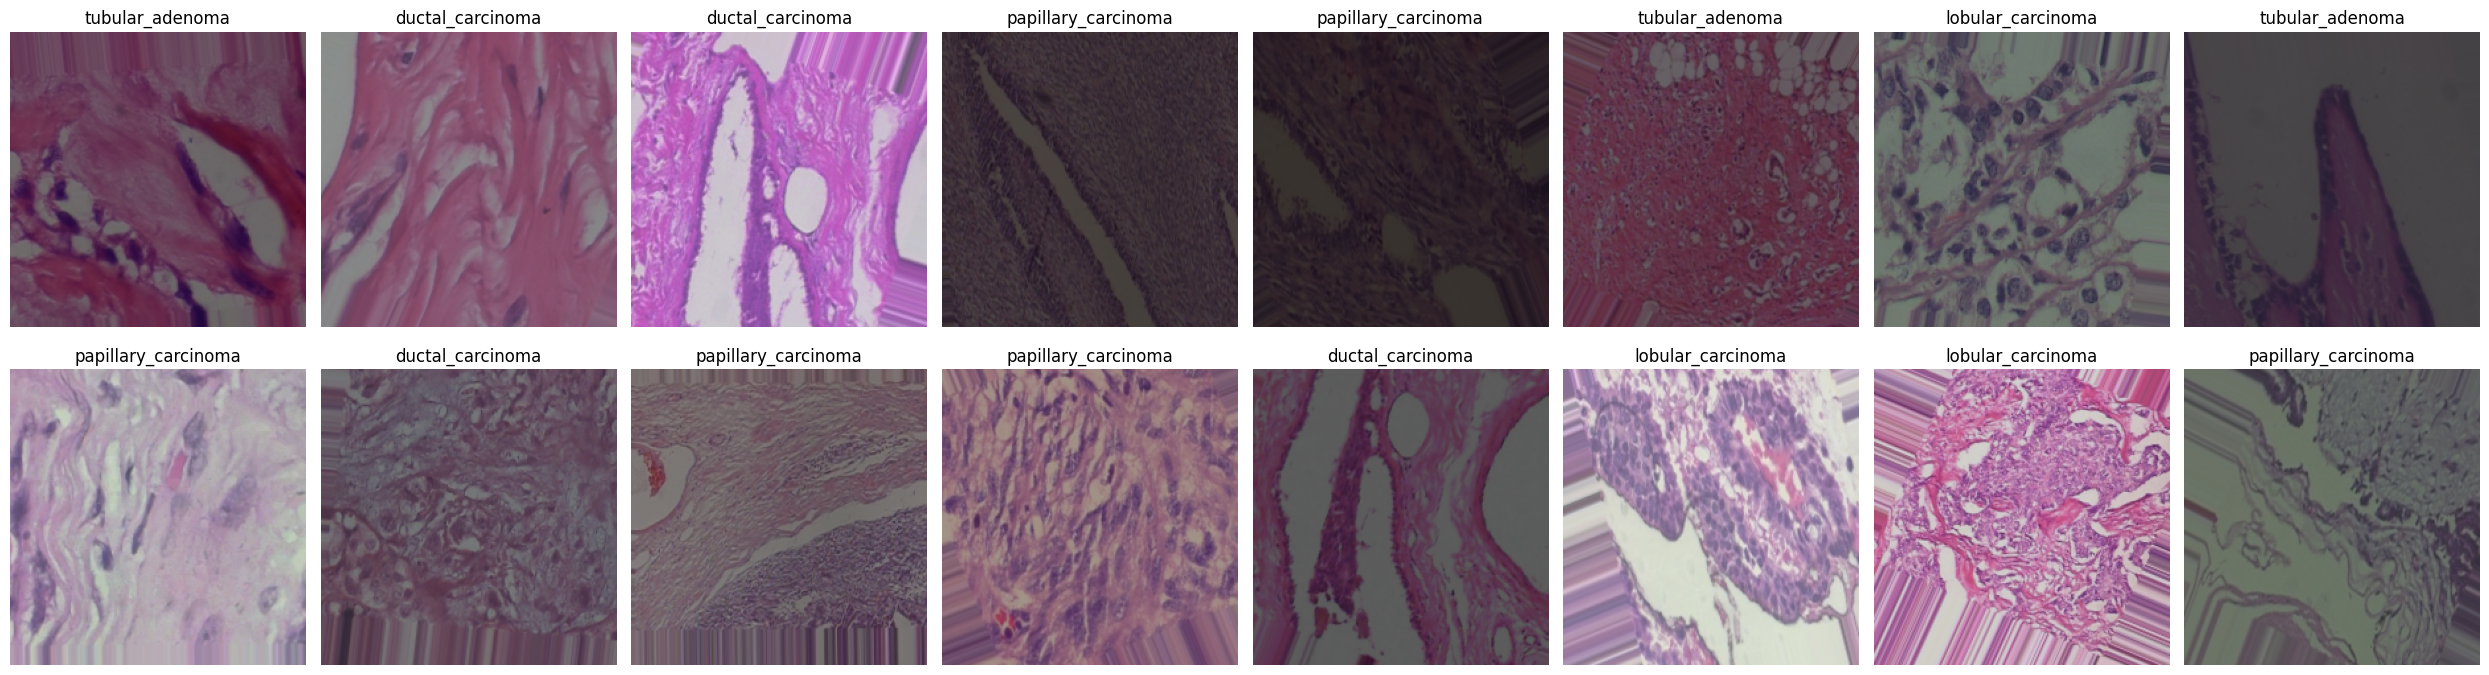

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma','ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def view_image(generator, col=8, row=2, size=(25, 7)):
    images, labels = next(generator)
    total = len(images)
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)

    for i in range(total):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


view_image(train_generator)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

def triple_attention(a, b, proj_dim=96, reduction=8, name=None):
    """
    a, b: tensors (B, H, W, C_a) and (B, H2, W2, C_b)
    Returns: tensor shaped like `a` (B, H, W, C_a) after combining channel, spatial, cross-attn.
    """

    # -------- channel attention (on a) ----------
    def channel_attention(x):
        ch = int(x.shape[-1])
        avg = layers.GlobalAveragePooling2D()(x)               # (B, C)
        dense1 = layers.Dense(max(ch // reduction, 4), activation='relu')(avg)
        dense2 = layers.Dense(ch, activation='sigmoid')(dense1)
        scale = layers.Reshape((1, 1, ch))(dense2)
        return layers.Multiply()([x, scale])

    # -------- spatial attention (on a) ----------
    def spatial_attention(x):
        avg_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
        max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])  # (B,H,W,2)
        attn = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
        return layers.Multiply()([x, attn])

    def cross_attention(a, b):
        q = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_q")(a)
        k = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_k")(b)
        v = layers.Conv2D(proj_dim, 1, padding='same', name=f"{name}_v")(b)

        # flatten
        qf = layers.Lambda(lambda t: tf.reshape(t, (tf.shape(t)[0], -1, tf.shape(t)[-1])))(q)
        kf = layers.Lambda(lambda t: tf.reshape(t, (tf.shape(t)[0], -1, tf.shape(t)[-1])))(k)
        vf = layers.Lambda(lambda t: tf.reshape(t, (tf.shape(t)[0], -1, tf.shape(t)[-1])))(v)

        scale = tf.math.sqrt(tf.cast(proj_dim, tf.float32))
        logits = layers.Lambda(lambda t: tf.matmul(t[0], t[1], transpose_b=True) / scale)([qf, kf])
        attn = layers.Activation("softmax")(logits)

        out = layers.Lambda(lambda t: tf.matmul(t[0], t[1]))([attn, vf])

        def unflatten_fn(inputs):
            x, feat = inputs 
            shape = tf.shape(feat)
            H = shape[1]
            W = shape[2]
            return tf.reshape(x, (shape[0], H, W, proj_dim))

        out = layers.Lambda(unflatten_fn)([out, a])

        out_proj = layers.Conv2D(a.shape[-1], 1, padding='same')(out)
        return layers.Add()([a, out_proj])

    # apply the three attentions
    ca = channel_attention(a)
    sa = spatial_attention(a)
    xa = cross_attention(a, b)

    # combine (you can sum or concatenate; sum keeps dims stable)
    out = layers.Add()([ca, sa, xa])
    out = layers.Activation('gelu')(out)
    return out

In [20]:
def freeze_and_inspect(base_model, freeze_until=0, branch_name="Branch"):
    print(f"\nFreezing first {freeze_until} layers of {branch_name}")
    
    for i, layer in enumerate(base_model.layers):
        if i < freeze_until:
            layer.trainable = False
        else:
            layer.trainable = True

        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [21]:
class GatedFusion(layers.Layer):
    def build(self, input_shape):
        _, c = input_shape[0]
        self.w_raw = self.add_weight(
            shape=(c,),
            initializer="zeros",
            trainable=True,
            name="gate_raw"
        )
    def call(self, inputs):
        f1, f2 = inputs
        gate = tf.sigmoid(self.w_raw)
        return gate * f1 + (1 - gate) * f2

In [22]:
def se_block(x, reduction=8):
    C = x.shape[-1]
    se = Dense(C // reduction, activation='relu')(x)
    se = Dense(C, activation='sigmoid')(se)
    return layers.Multiply()([x, se])

In [23]:
# input_shape=(224,224,3)

# eff = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
# eff.summary()

# mob = MobileNetV3Large(include_top=False, weights="imagenet", input_shape=input_shape)
# for layer in mob.layers:
#     print(layer.name)

In [24]:
from tensorflow.keras import optimizers
from keras import Sequential, Model, backend as K
from keras.layers import Dense, Input , Flatten, Conv2D, UpSampling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0,MobileNetV3Large


def build_dual_branch_model(input_shape=(224,224,3), num_classes=8, proj_dim=512):

    inputs = layers.Input(shape=input_shape)

    # ===================== EfficientNetB0 =====================
    eff = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)

    freeze_and_inspect(eff, freeze_until=80, branch_name="EfficientNetB0")

    feat28_eff = eff.get_layer("block3b_add").output                # 28×28
    feat14_eff = eff.get_layer("block6a_expand_activation").output  # 14×14
    high_eff = eff.output                                           # 7×7

    eff_model = models.Model(eff.input, [feat28_eff, feat14_eff, high_eff],name="EfficientNetB0_Branch")
    fe28_e, fe14_e, f1_map = eff_model(inputs)

    # ===================== MobileNetV3-Large =====================
    mob = MobileNetV3Large(include_top=False, weights="imagenet", input_shape=input_shape)

    freeze_and_inspect(mob, freeze_until=80, branch_name="MobileNetV3Large")

    feat28_mob = mob.get_layer("expanded_conv_5_add").output        # 28×28
    feat14_mob = mob.get_layer("expanded_conv_12_expand").output    # 14×14
    high_mob = mob.output                                           # 7×7

    mob_model = models.Model(mob.input, [feat28_mob, feat14_mob, high_mob],name="MobileNetV3Large_Branch")
    fe28_m, fe14_m, f2_map = mob_model(inputs)

    # ===================== 28×28 TRIPLE ATTENTION =====================
    ta28_e = triple_attention(fe28_e, fe28_m, name="ta_28_eff",proj_dim=96)
    ta28_m = triple_attention(fe28_m, fe28_e, name="ta_28_mob",proj_dim=96)

    fused28 = layers.Concatenate()([
        GlobalAveragePooling2D()(ta28_e),
        GlobalAveragePooling2D()(ta28_m),
    ])

    # ===================== 14×14 TRIPLE ATTENTION =====================
    ta14_e = triple_attention(fe14_e, fe14_m, name="ta_14_eff",proj_dim=96)
    ta14_m = triple_attention(fe14_m, fe14_e, name="ta_14_mob",proj_dim=96)

    fused14 = layers.Concatenate()([
        GlobalAveragePooling2D()(ta14_e),
        GlobalAveragePooling2D()(ta14_m),
    ])

    # ===================== HIGH-LEVEL PROJECTION =====================
    f1 = GlobalAveragePooling2D()(f1_map)
    f2 = GlobalAveragePooling2D()(f2_map)

    proj_f1 = Dense(proj_dim)(f1)
    proj_f1 = BatchNormalization()(proj_f1)
    proj_f1 = layers.Activation("gelu")(proj_f1)

    proj_f2 = Dense(proj_dim)(f2)
    proj_f2 = BatchNormalization()(proj_f2)
    proj_f2 = layers.Activation("gelu")(proj_f2)

    # ===================== GATED FUSION =====================
    fused_high = GatedFusion()([proj_f1, proj_f2])

    # ===================== SE AFTER HIGH FUSION =====================
    fused_high = se_block(fused_high)

    # ===================== FINAL CONCAT FUSION =====================
    fused = layers.Concatenate()([fused28, fused14, fused_high])

    fused = Dense(512, activation='gelu')(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.3)(fused)

    fused = Dense(256, activation='gelu')(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.25)(fused)

    outputs = Dense(num_classes, activation="softmax")(fused)

    model = models.Model(inputs, outputs, name="EffNetB0_MobileNetV3_fusion")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall(), tf.keras.metrics.AUC()]
    )

    return model

In [25]:
tf.keras.backend.clear_session()
model = build_dual_branch_model()
model.summary()

I0000 00:00:1763465372.377548      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763465372.378286      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Freezing first 80 layers of EfficientNetB0
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Freezing first 80 layers of MobileNetV3Large


Model: "EffNetB0_MobileNetV3_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EfficientNetB0_Bra… │ [(None, 28, 28,   │  4,049,571 │ input_layer[0][0] │
│ (Functional)        │ 40), (None, 14,   │            │                   │
│                     │ 14, 672), (None,  │            │                   │
│                     │ 7, 7, 1280)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large_B… │ [(None, 28, 28,   │  2,996,352 │ input_layer[0][0] │
│ (Functional)        │ 40), (None, 14,   │            │                   │
│                     │ 14, 672), (None,  │            │                   │
│                     │ 7, 7, 960)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_28_eff_q         │ (None, 28, 28,    │      3,936 │ EfficientNetB0_B… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_28_eff_k         │ (None, 28, 28,    │      3,936 │ MobileNetV3Large… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_28_mob_q         │ (None, 28, 28,    │      3,936 │ MobileNetV3Large… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_28_mob_k         │ (None, 28, 28,    │      3,936 │ EfficientNetB0_B… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_14_eff_q         │ (None, 14, 14,    │     64,608 │ EfficientNetB0_B… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_14_eff_k         │ (None, 14, 14,    │     64,608 │ MobileNetV3Large… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_14_mob_q         │ (None, 14, 14,    │     64,608 │ MobileNetV3Large… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ta_14_mob_k         │ (None, 14, 14,    │     64,608 │ EfficientNetB0_B… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 96)  │          0 │ ta_28_eff_q[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 96)  │          0 │ ta_28_eff_k[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, None, 96)  │          0 │ ta_28_mob_q[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, None, 96)  │          0 │ ta_28_mob_k[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, None, 96)  │          0 │ ta_14_eff_q[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, None, 96)  │          0 │ ta_14_eff_k[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,170,729 (38.80 MB)

 Trainable params: 9,957,648 (37.99 MB)

 Non-trainable params: 213,081 (832.35 KB)

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    '/kaggle/working/efficientnet_plus_densenet_multiple_with_cbam_on_Breakhis_multiclass_model_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      
    factor=0.5,              
    patience=2,              
    verbose=1,               
    min_lr=1e-7              
)

csv_logger = CSVLogger('training_log.csv', append=False)

In [27]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint,reduce_lr,early_stop,csv_logger]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1763465443.211845      67 service.cc:148] XLA service 0x7c654416de10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763465443.213481      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763465443.213500      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763465452.833001      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1763465465.360330      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763465465.495708      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763465465.808484      67 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5907 - auc: 0.8869 - loss: 1.2123 - precision: 0.6735 - recall: 0.5179
Epoch 1: val_accuracy improved from -inf to 0.80151, saving model to /kaggle/working/efficientnet_plus_densenet_multiple_with_cbam_on_Breakhis_multiclass_model_epoch_01_valacc_0.8015.weights.h5
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2693s 417ms/step - accuracy: 0.5907 - auc: 0.8869 - loss: 1.2122 - precision: 0.6735 - recall: 0.5180 - val_accuracy: 0.8015 - val_auc: 0.9727 - val_loss: 0.5920 - val_precision: 0.8195 - val_recall: 0.7881 - learning_rate: 1.0000e-04
Epoch 2/15
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9173 - auc: 0.9943 - loss: 0.2442 - precision: 0.9292 - recall: 0.9063
Epoch 2: val_accuracy improved from 0.80151 to 0.91706, saving model to /kaggle/working/efficientnet_plus_densenet_multiple_with_cbam_on_Breakhis_multiclass_model_epoch_02_valacc_0.9171.weights.h5
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2445s 397ms/step - accuracy: 0.9173 - auc

In [28]:
loss, accuracy,auc,precision,recall = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")

425/425 ━━━━━━━━━━━━━━━━━━━━ 89s 208ms/step - accuracy: 0.9862 - auc: 0.9994 - loss: 0.0450 - precision: 0.9862 - recall: 0.9862
Test Loss: 0.0308
Test Accuracy: 99.09%
Test Precision: 99.09%
Test Recall: 99.94%


In [29]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

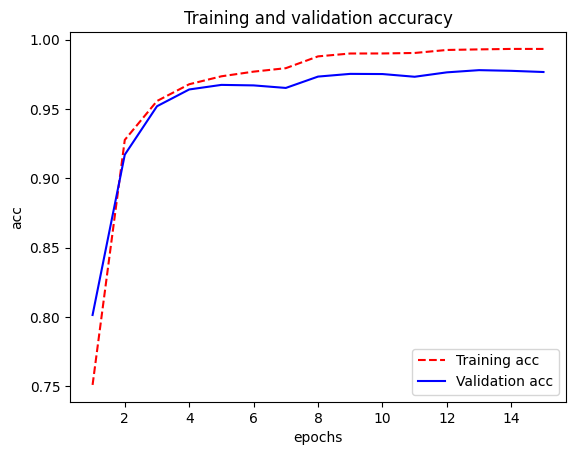

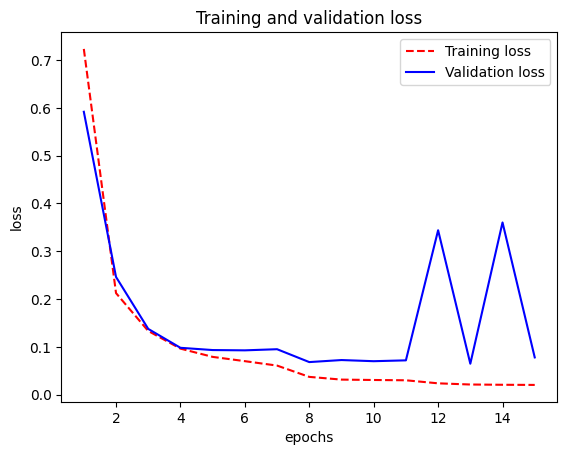

<Figure size 640x480 with 0 Axes>

In [30]:
plot_history(history)

425/425 ━━━━━━━━━━━━━━━━━━━━ 100s 208ms/step


<Figure size 800x800 with 0 Axes>

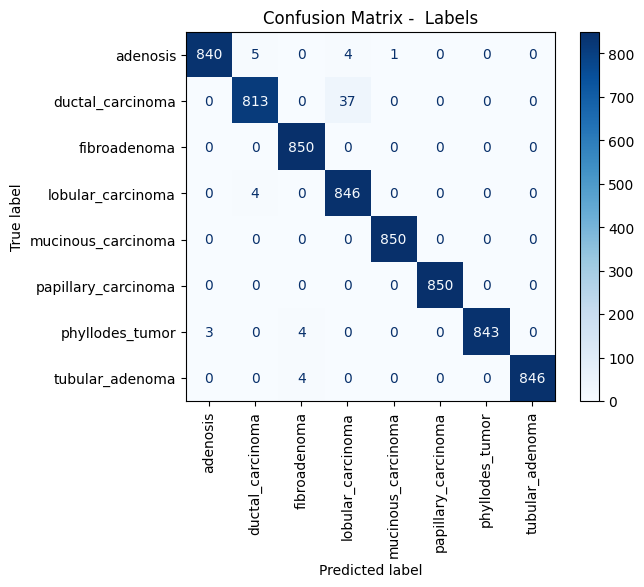

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(test_generator)       # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_generator.classes                    # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_generator.class_indices.keys())
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix -  Labels")
plt.show()

In [32]:
df = pd.DataFrame(history.history)
df['epoch'] = range(1, len(df) + 1)

df.to_csv('training_history.csv', index=False)